# 1: Upload the Dataset
In this step, we upload the essay dataset (`essay_dataset.csv`) to the Colab environment.  
The dataset contains student essays along with various scoring metrics such as grammar, coherence, and content relevance.  

After uploading, we load it into a pandas DataFrame to perform initial inspection and preprocessing. This allows us to check the size of the dataset and preview the first few rows.


In [ ]:
from google.colab import files
print("📤 Please upload your essay_dataset.csv file...")
uploaded = files.upload()

import io
import pandas as pd
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"✅ File '{filename}' uploaded successfully. Shape: {df.shape}")


📤 Please upload your essay_dataset.csv file...


Saving essay_dataset.csv to essay_dataset (2).csv
✅ File 'essay_dataset (2).csv' uploaded successfully. Shape: (1000, 11)


# 2: Install Required Libraries
We need several libraries for natural language processing (NLP), machine learning, and evaluation:

- `transformers` and `sentence-transformers` for BERT-based embeddings and models.
- `datasets` and `evaluate` for dataset handling and evaluation metrics.
- `scikit-learn` for preprocessing and model evaluation.
- `language_tool_python` for grammar checking.
- `matplotlib` for visualizations.
- `tqdm` for progress bars in loops.

These libraries will allow us to preprocess essays, generate embeddings, train models, and compute evaluation metrics.


In [ ]:


# ================================================
# 🪄 STEP 1: INSTALL REQUIRED LIBRARIES
# ================================================
!pip install -q transformers==4.44.2 datasets==2.19.1 evaluate==0.4.1 accelerate==0.33.0
!pip install -q sentence-transformers==3.0.1 scikit-learn==1.5.0 tqdm==4.66.4 matplotlib

!pip install --quiet language_tool_python
import language_tool_python

# Initialize once
tool = language_tool_python.LanguageTool('en-US')



# 3: Import Libraries for Data Processing and Modeling
We import libraries for:

- Numerical operations (`numpy`)
- NLP embeddings and similarity (`sentence-transformers`)
- Deep learning (`torch`, `torch.nn`)
- Progress tracking (`tqdm`)
- Regex processing (`re`)
- Transformers models and training (`transformers`)
- Dataset handling (`datasets`)
- Statistical evaluation (`scipy.stats`, `sklearn.metrics`)
- Visualization (`matplotlib`)

These imports provide all the necessary tools for preprocessing essays, building models, and evaluating predictions.


In [ ]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import re
import os

from transformers import Trainer, TrainingArguments, AutoTokenizer
from datasets import Dataset
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt



/usr/local/lib/python3.12/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 4: Define BERT Multi-Output Regressor
We define a PyTorch model class `BertMultiRegressor` for predicting multiple scores at once (grammar, coherence, and content relevance).  

The model uses a pre-trained BERT backbone and adds a linear layer on top to produce the desired number of outputs.  
Mean Squared Error (MSE) is used as the loss function during training.


In [ ]:
from transformers import BertModel
import torch.nn as nn
import torch

class BertMultiRegressor(nn.Module):
    def __init__(self, model_ckpt, n_outputs=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_ckpt)
        self.regressor = nn.Linear(self.bert.config.hidden_size, n_outputs)  # 4 outputs: final, grammar, coherence, relevance

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled = outputs.pooler_output
        logits = self.regressor(pooled)

        loss = None
        if labels is not None:
            labels = labels.float()
            loss_fn = nn.MSELoss()
            loss = loss_fn(logits, labels)  # shape: [batch_size, 4]

        return {"loss": loss, "logits": logits}



# 5: View Dataset and Remove Missing Values
Inspect the dataset by checking its shape and previewing the first few rows.  
This allows us to confirm the dataset loaded correctly and understand the structure of the essays and scores.

**Normalize Tokens and Remove Duplicates**

We create a "token signature" for each essay to normalize words and remove punctuation.  

After normalization, we drop duplicate essays based on `word_tokens` and `final_score` to ensure each essay is unique in the dataset.



In [ ]:

print("📂 Loaded dataset shape:", df.shape)
df.head()

important_cols = ["essay_text", "grammar_score", "coherence_score", "content_relevance_score"]
initial_count = df.shape[0]
df = df.dropna(subset=important_cols)
dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 4 (missing values)")
initial_count = df.shape[0]


📂 Loaded dataset shape: (1000, 11)
🔻 Dropped 0 rows after STEP 4 (missing values)


# 6: Normalize Tokens and Remove Duplicates
We create a "token signature" for each essay to normalize words and remove punctuation.  

After normalization, we drop duplicate essays based on `word_tokens` and `final_score` to ensure each essay is unique in the dataset.


In [ ]:


def normalize_tokens(x):
    if isinstance(x, list):
        return " ".join(x)
    elif isinstance(x, str):
        return " ".join(re.findall(r"\b\w[\w\-]*\b", x))
    else:
        return str(x)

df["token_signature"] = df["word_tokens"].apply(normalize_tokens)

# Drop duplicates based on both normalized tokens and final_score
df = df.drop_duplicates(subset=["token_signature", "final_score"]).reset_index(drop=True)

dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 5a (duplicates based on word_tokens + final_score)")
initial_count = df.shape[0]


🔻 Dropped 6 rows after STEP 5a (duplicates based on word_tokens + final_score)


# 7: Remove Short Essays
Essays with very few characters are likely uninformative.  
We remove essays shorter than 10 characters to improve data quality for training and evaluation.


In [ ]:
df = df[df["essay_text"].str.strip().str.len() > 10].reset_index(drop=True)
dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 5b (short essays)")
initial_count = df.shape[0]

🔻 Dropped 0 rows after STEP 5b (short essays)


# 8: Calculate Final Score
If the `final_score` column does not exist, we compute it as the mean of grammar, coherence, and content relevance scores.  

Rows with missing `final_score` are dropped to ensure clean data for modeling.


In [ ]:
if "final_score" not in df.columns:
    df["final_score"] = df[["grammar_score", "coherence_score", "content_relevance_score"]].mean(axis=1)
df = df.dropna(subset=["final_score"]).reset_index(drop=True)
dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 6 (missing final_score)")
initial_count = df.shape[0]

🔻 Dropped 0 rows after STEP 6 (missing final_score)


# 9: Assign Essay Topics
We create a lowercase version of essays for consistent text matching.  

Using predefined keyword lists for different topics (education, environment, AI, health), each essay is assigned a topic based on the frequency of keyword matches.  
If no keywords match, the essay is labeled as "other".


In [ ]:
df["_essay_lower"] = df["essay_text"].str.lower()

topic_keywords = {
    "education": [
        "education", "students", "school", "learning", "teacher", "curriculum", "university",
        "classroom", "academic", "homework", "exam", "literacy", "pedagogy", "scholarship",
        "principal", "tuition", "degree", "college", "study", "textbook"
    ],
    "environment": [
        "environment", "climate", "pollution", "sustainability", "conservation", "ecosystem", "recycle",
        "biodiversity", "carbon", "greenhouse", "global warming", "deforestation", "renewable",
        "solar", "wind", "compost", "emissions", "habitat", "ecology"
    ],
    "ai": [
        "ai", "artificial intelligence", "machine learning", "deep learning", "neural network", "automation", "algorithm",
        "chatbot", "data science", "natural language processing", "computer vision", "robotics",
        "intelligent systems", "predictive", "modeling", "training data", "generative", "reinforcement learning"
    ],
    "health": [
        "health", "medicine", "disease", "healthcare", "nutrition", "wellness", "mental health",
        "hospital", "doctor", "patient", "treatment", "vaccine", "fitness", "exercise",
        "public health", "epidemic", "therapy", "diagnosis", "symptoms", "medical"
    ]
}


def assign_topic(text):
    counts = {t:0 for t in topic_keywords}
    for t, kws in topic_keywords.items():
        for kw in kws:
            counts[t] += len(re.findall(r"\b" + re.escape(kw) + r"\b", text))
    best = max(counts.items(), key=lambda x: x[1])
    return best[0] if best[1] > 0 else "other"

tqdm.pandas()
df["topic"] = df["_essay_lower"].progress_apply(assign_topic)


100%|██████████| 994/994 [00:01<00:00, 795.58it/s]


# 10: Define Topic Prompts and Input Text
We define a set of prompts for each essay topic. These prompts serve as context for computing semantic relevance and for the multi-output model input.  

Next, we create a column `input_text` that includes the topic, corresponding prompt, and the essay text itself. This will later be tokenized for BERT.


In [ ]:
topic_prompts = {
    "education": "Discuss the importance of education in modern society.",
    "environment": "Explain how humans can protect and improve the environment.",
    "ai": "Discuss the impact of artificial intelligence on society and daily life.",
    "health": "Explain why health and healthcare are important for society.",
    "other": "Discuss the given topic."
}
df["input_text"] = df.apply(
    lambda r: (
        f"Topic: {r['topic']}. Prompt: {topic_prompts.get(r['topic'], topic_prompts['other'])}\n\n"
        f"Essay: {r['essay_text']}"
    ),
    axis=1
)


# 11: Prepare Labels
We extract the essay scores (grammar, coherence, content relevance) and store them as a list in a new column `labels`.  

This format is suitable for multi-output regression with BERT.


In [ ]:
score_cols = ["grammar_score", "coherence_score", "content_relevance_score"]
df["labels"] = df[score_cols].apply(lambda x: [float(i) for i in x], axis=1)





# 12: Compute Semantic Similarity Scores
We compute semantic similarity between each essay and its topic prompt using a SentenceTransformer model.  

The similarity score ranges from 0 to 1 and will be included as an additional feature in the input.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("\n💻 Using device for embeddings:", device)
embed_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

prompt_embs = {t: embed_model.encode(p, convert_to_tensor=True) for t, p in topic_prompts.items()}

batch_size = 64
semantic_scores = []
texts = df["essay_text"].tolist()
topics = df["topic"].tolist()

for i in tqdm(range(0, len(df), batch_size), desc="Embedding batches"):
    batch_texts = texts[i:i+batch_size]
    batch_topics = topics[i:i+batch_size]
    batch_embs = embed_model.encode(batch_texts, convert_to_tensor=True)
    for emb, t in zip(batch_embs, batch_topics):
        prompt_e = prompt_embs.get(t, prompt_embs["other"])
        sim = util.cos_sim(emb, prompt_e).item()
        sim01 = (sim + 1.0) / 2.0
        semantic_scores.append(sim01)

df["semantic_score"] = semantic_scores



💻 Using device for embeddings: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Embedding batches: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s]


# 13: Update Input Text with Scores
We append the computed semantic score and the individual essay scores to the `input_text` column.  

This enriched input will be fed into the BERT model for training.


In [ ]:
df["input_text"] = df.apply(
    lambda r: (
        f"{r['input_text']}\n\n"
        f"Semantic Score: {r['semantic_score']:.2f}. "
        f"Grammar: {r['grammar_score']:.2f}, Coherence: {r['coherence_score']:.2f}, Relevance: {r['content_relevance_score']:.2f}"
    ),
    axis=1
)


# 14: Final Cleanup and Save Preprocessed Dataset
Drop temporary columns, create a short essay preview, and save the preprocessed dataset to a CSV.  

This ensures that the data is ready for tokenization and model training.


In [ ]:
df = df.drop(columns=["_essay_lower"])
df["essay_preview"] = df["essay_text"].str.slice(0,160)
df.to_csv("essay_dataset_preprocessed.csv", index=False)
print(f"\n✅ STEP 11 DONE: Preprocessing complete.")
print("💾 Saved as essay_dataset_preprocessed.csv")
print("📏 Final dataset shape:", df.shape)



✅ STEP 11 DONE: Preprocessing complete.
💾 Saved as essay_dataset_preprocessed.csv
📏 Final dataset shape: (994, 17)


# 15: Tokenization
We use the `bert-base-uncased` tokenizer to convert input text into token IDs suitable for BERT.  

We split the dataset into training and testing sets (80/20), store the original row indices for reconstruction, and apply truncation/padding to a maximum length of 512 tokens.


In [ ]:

print("\n🔤 Starting tokenization using bert-base-uncased tokenizer...")

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Store original row index for later reconstruction
df["row_id"] = df.index

dataset = Dataset.from_pandas(df[["row_id", "input_text", "labels"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)


# 🧠 Tokenization with truncation + padding
def tokenize_function(examples):
    return tokenizer(
        examples["input_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_train = dataset["train"].map(tokenize_function, batched=True)
tokenized_test = dataset["test"].map(tokenize_function, batched=True)

print("✅ Tokenization complete. Example keys:", tokenized_train.features.keys())

# Load multi-output model
model = BertMultiRegressor(model_ckpt, n_outputs=3)





🔤 Starting tokenization using bert-base-uncased tokenizer...


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/795 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

✅ Tokenization complete. Example keys: dict_keys(['row_id', 'input_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'])


# 16: Define Evaluation Metrics
We define a `compute_metrics` function for multi-output regression.  

Metrics include:
- Pearson correlation
- Mean squared error (MSE)
- Mean absolute error (MAE)
- R² score  

Metrics are computed for each output (grammar, coherence, relevance) and an overall average MSE.


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.squeeze(predictions)

    # If labels are 2D, compute per-output metric
    if preds.ndim > 1:
        metrics = {}
        mse_list = []
        for i, name in enumerate(["grammar", "coherence", "relevance"]):
            metrics[f"eval_{name}_pearsonr"] = float(pearsonr(preds[:, i], labels[:, i])[0])
            mse_val = float(np.mean((preds[:, i] - labels[:, i])**2))
            metrics[f"eval_{name}_mse"] = mse_val
            mse_list.append(mse_val)
            metrics[f"eval_{name}_mae"] = float(mean_absolute_error(labels[:, i], preds[:, i]))
            metrics[f"eval_{name}_r2"] = float(r2_score(labels[:, i], preds[:, i]))

        # Overall average MSE across all outputs
        metrics["eval_mse"] = float(np.mean(mse_list))
        return metrics
    else:
        corr, _ = pearsonr(preds, labels)
        mse = np.mean((preds - labels)**2)
        mae = mean_absolute_error(labels, preds)
        r2 = r2_score(labels, preds)
        return {
            "eval_pearsonr": float(corr),
            "eval_mse": float(mse),
            "eval_mae": float(mae),
            "eval_r2": float(r2)
        }


# 17: Initialize Trainer and fine-tune Model
We define training arguments (epochs, batch size, learning rate, weight decay, logging, etc.) and initialize the `Trainer`.  

The model is trained using multi-output regression and evaluated on the test set at the end of each epoch.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,             # From trial result
    per_device_eval_batch_size=16,
    warmup_steps=100,                           # Updated from best trial
    learning_rate=3e-05,                        # Added from best trial
    weight_decay=0.01,                          # From best trial
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mse",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),
    report_to=[]
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("✅ Trainer initialized. Starting training...")
trainer.train()


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


✅ Trainer initialized. Starting training...


Epoch,Training Loss,Validation Loss,Grammar Pearsonr,Grammar Mse,Grammar Mae,Grammar R2,Coherence Pearsonr,Coherence Mse,Coherence Mae,Coherence R2,Relevance Pearsonr,Relevance Mse,Relevance Mae,Relevance R2,Mse
1,No log,33.538681,0.159736,28.897549,5.161327,-11.664208,0.182027,34.430508,5.704536,-17.027493,0.204377,37.287998,5.953232,-18.991030,33.538685
2,34.980500,7.471045,-0.011316,7.134996,2.203886,-2.126877,0.100848,7.275476,2.317553,-2.809371,-0.105413,8.002664,2.479213,-3.290428,7.471045
3,34.980500,2.057009,-0.043693,2.348430,1.336862,-0.029188,0.183811,1.921192,1.176332,-0.005918,-0.016111,1.901405,1.195323,-0.019391,2.057009
4,2.973200,2.055086,-0.001039,2.386722,1.349133,-0.045969,0.071618,1.903829,1.168449,0.003173,-0.149205,1.874705,1.189856,-0.005076,2.055085
5,2.973200,1.819504,0.541888,1.984206,1.226770,0.130432,0.430823,1.676230,1.092939,0.122342,0.510498,1.798077,1.130394,0.036006,1.819504
6,1.883800,1.421042,0.537314,1.636161,1.059586,0.282960,0.530928,1.478088,1.042069,0.226087,0.658470,1.148876,0.889667,0.384059,1.421042
7,1.883800,1.019564,0.720169,1.256236,0.953233,0.449461,0.553118,1.338702,1.003917,0.299068,0.890384,0.463755,0.561737,0.751369,1.019564
8,1.117000,0.844734,0.792858,0.905625,0.785664,0.603114,0.602973,1.227907,0.955669,0.357080,0.910975,0.400670,0.528123,0.785191,0.844734
9,1.117000,0.677643,0.842240,0.740924,0.716295,0.675294,0.726844,0.970364,0.821335,0.491927,0.912366,0.321642,0.464714,0.827560,0.677643
10,0.748300,0.576370,0.885998,0.573147,0.609458,0.748821,0.779523,0.834726,0.744563,0.562945,0.922039,0.321236,0.471676,0.827777,0.576370


TrainOutput(global_step=500, training_loss=8.340552932739257, metrics={'train_runtime': 769.2919, 'train_samples_per_second': 10.334, 'train_steps_per_second': 0.65, 'total_flos': 0.0, 'train_loss': 8.340552932739257, 'epoch': 10.0})

# 18: Evaluate Model
Evaluate the trained model on the test set. Print key evaluation metrics for grammar, coherence, relevance, and overall MSE.


In [ ]:
eval_results = trainer.evaluate()
print("\n📊 Evaluation Results:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")



📊 Evaluation Results:
eval_grammar_pearsonr: 0.8860
eval_grammar_mse: 0.5731
eval_grammar_mae: 0.6095
eval_grammar_r2: 0.7488
eval_coherence_pearsonr: 0.7795
eval_coherence_mse: 0.8347
eval_coherence_mae: 0.7446
eval_coherence_r2: 0.5629
eval_relevance_pearsonr: 0.9220
eval_relevance_mse: 0.3212
eval_relevance_mae: 0.4717
eval_relevance_r2: 0.8278
eval_mse: 0.5764
eval_loss: 0.5764
eval_runtime: 1.6161
eval_samples_per_second: 123.1370
eval_steps_per_second: 8.0440
epoch: 10.0000


# 19: Plot Evaluation Metrics
Visualize training progress using Matplotlib. We plot:
- MSE over epochs
- Pearson correlation over epochs
- R² over epochs  

This helps to monitor model performance during training.


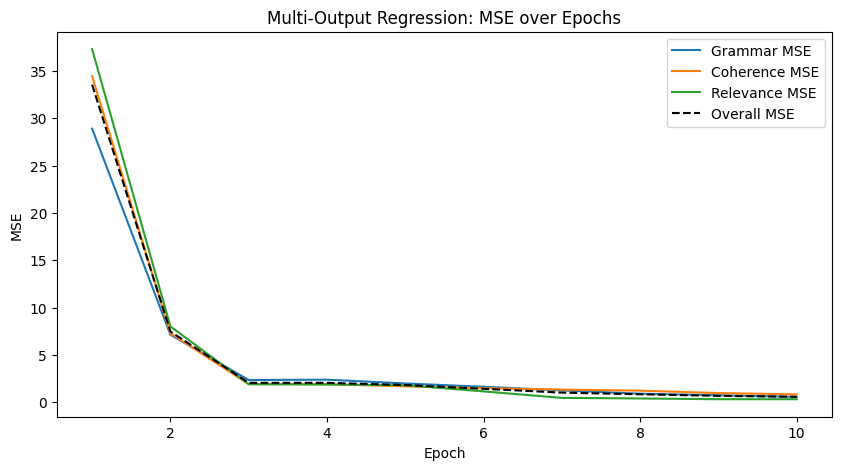

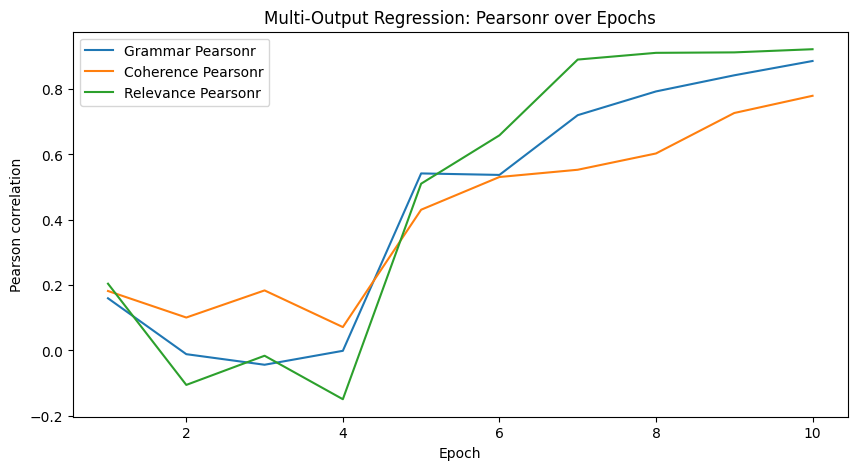

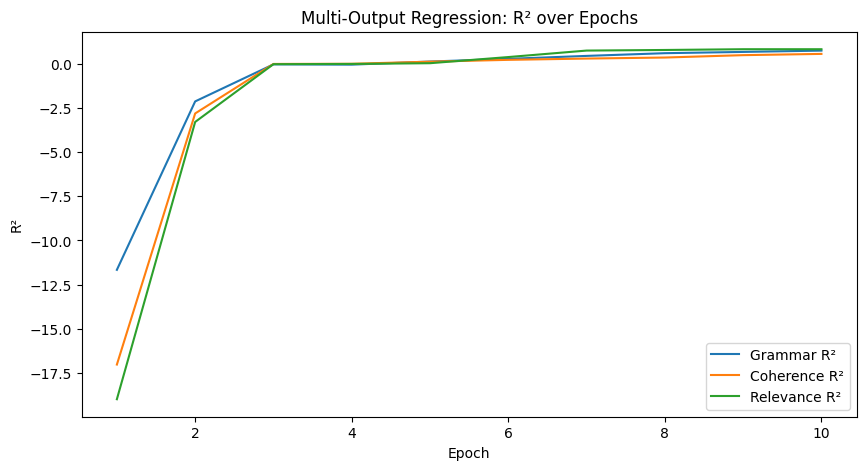

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert trainer log history to DataFrame
logs = pd.DataFrame(trainer.state.log_history)

# Only keep evaluation rows
eval_logs = logs[logs['epoch'].notnull() & logs['eval_loss'].notnull()]

# Metrics to plot
metrics = ["eval_grammar_mse", "eval_coherence_mse", "eval_relevance_mse",
           "eval_grammar_mae", "eval_coherence_mae", "eval_relevance_mae",
           "eval_grammar_pearsonr", "eval_coherence_pearsonr", "eval_relevance_pearsonr",
           "eval_grammar_r2", "eval_coherence_r2", "eval_relevance_r2",
           "eval_mse"]  # overall MSE

# Plot MSE per output + overall
plt.figure(figsize=(10,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_grammar_mse"], label="Grammar MSE")
plt.plot(eval_logs["epoch"], eval_logs["eval_coherence_mse"], label="Coherence MSE")
plt.plot(eval_logs["epoch"], eval_logs["eval_relevance_mse"], label="Relevance MSE")
plt.plot(eval_logs["epoch"], eval_logs["eval_mse"], label="Overall MSE", linestyle='--', color='black')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Multi-Output Regression: MSE over Epochs")
plt.legend()
plt.show()

# Plot Pearson correlation per output
plt.figure(figsize=(10,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_grammar_pearsonr"], label="Grammar Pearsonr")
plt.plot(eval_logs["epoch"], eval_logs["eval_coherence_pearsonr"], label="Coherence Pearsonr")
plt.plot(eval_logs["epoch"], eval_logs["eval_relevance_pearsonr"], label="Relevance Pearsonr")
plt.xlabel("Epoch")
plt.ylabel("Pearson correlation")
plt.title("Multi-Output Regression: Pearsonr over Epochs")
plt.legend()
plt.show()

# Plot R² per output
plt.figure(figsize=(10,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_grammar_r2"], label="Grammar R²")
plt.plot(eval_logs["epoch"], eval_logs["eval_coherence_r2"], label="Coherence R²")
plt.plot(eval_logs["epoch"], eval_logs["eval_relevance_r2"], label="Relevance R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("Multi-Output Regression: R² over Epochs")
plt.legend()
plt.show()


# 20: Generate Ground-Truth Predictions
We use the trained model to generate predictions on the test set.  

Steps:
1. Predict grammar, coherence, and relevance scores.
2. Extract true labels for comparison.
3. Store row IDs to map predictions back to original essays.
4. Build a numeric-only evaluation table and compute final scores and errors.
5. Save numeric predictions to CSV for further analysis.


In [ ]:
import pandas as pd
import numpy as np

print("\n📝 Generating full ground-truth evaluation...")

# 1️⃣ Get predictions (multi-output)
raw_preds = trainer.predict(tokenized_test)
pred_scores = raw_preds.predictions  # shape: [num_samples, 3]

# 2️⃣ Extract true labels
true_scores = np.array(dataset["test"]["labels"])  # shape: [num_samples, 3]

# 3️⃣ Extract row IDs for correct mapping
test_row_ids = dataset["test"]["row_id"]

# 4️⃣ Build numeric-only evaluation table
results_df = pd.DataFrame({
    "row_id": test_row_ids,
    "true_grammar": true_scores[:, 0],
    "true_coherence": true_scores[:, 1],
    "true_relevance": true_scores[:, 2],
    "pred_grammar": pred_scores[:, 0],
    "pred_coherence": pred_scores[:, 1],
    "pred_relevance": pred_scores[:, 2],
})

# Compute final score and errors
results_df["true_final"] = results_df[["true_grammar", "true_coherence", "true_relevance"]].mean(axis=1)
results_df["pred_final"] = results_df[["pred_grammar", "pred_coherence", "pred_relevance"]].mean(axis=1)
results_df["error_final"] = results_df["pred_final"] - results_df["true_final"]
results_df["abs_error_final"] = results_df["error_final"].abs()

# Save numeric results
results_df.to_csv("prediction_results_multioutput.csv", index=False)
print("💾 Saved prediction_results_multioutput.csv (numeric results only)")

# 5️⃣ Merge with original essays using row_id
full_results = results_df.merge(
    df[["row_id", "essay_text"]],
    on="row_id",
    how="left"
)

# Rearrange columns
full_results = full_results[[
    "essay_text",
    "true_final",
    "pred_final",
    "error_final",
    "abs_error_final",
    "true_grammar",
    "pred_grammar",
    "true_coherence",
    "pred_coherence",
    "true_relevance",
    "pred_relevance",
    "row_id"
]]

# Save full results
full_results.to_csv("essay_ground_truth_predictions_multioutput.csv", index=False)
print("💾 Saved essay_ground_truth_predictions_multioutput.csv (includes essays + scores)")

print("\n📘 Example rows with essays:")
print(full_results.head(5))

# 6️⃣ Identify worst predictions
worst_df = full_results.sort_values(by="abs_error_final", ascending=False).head(15)
worst_df.to_csv("worst_predictions_multioutput.csv", index=False)

print("⚠️ Saved worst_predictions_multioutput.csv (top 15 highest errors)")
print("\n🚨 Top 5 Worst Predictions:")
print(worst_df.head(5))



📝 Generating full ground-truth evaluation...


💾 Saved prediction_results_multioutput.csv (numeric results only)
💾 Saved essay_ground_truth_predictions_multioutput.csv (includes essays + scores)

📘 Example rows with essays:
                                          essay_text  true_final  pred_final  \
0  Water pollution affects both human health and ...    6.510000    6.269531   
1  Education equips students with knowledge and c...    5.963333    5.787760   
2  Water pollution affects both human health and ...    7.606667    7.369792   
3  Artificial intelligence is transforming educat...    9.110000    8.627604   
4  Education equips students with knowledge and c...    7.103333    7.117188   

   error_final  abs_error_final  true_grammar  pred_grammar  true_coherence  \
0    -0.240469         0.240469          5.81      5.753906            7.39   
1    -0.175573         0.175573          5.52      5.691406            7.16   
2    -0.236875         0.236875          5.69      6.203125            8.01   
3    -0.482396         0.4

# Step 21: Visualize Predicted vs. True Final Scores
We create a scatter plot of predicted vs. true final scores to evaluate model performance visually.  

The red dashed diagonal line represents perfect predictions.


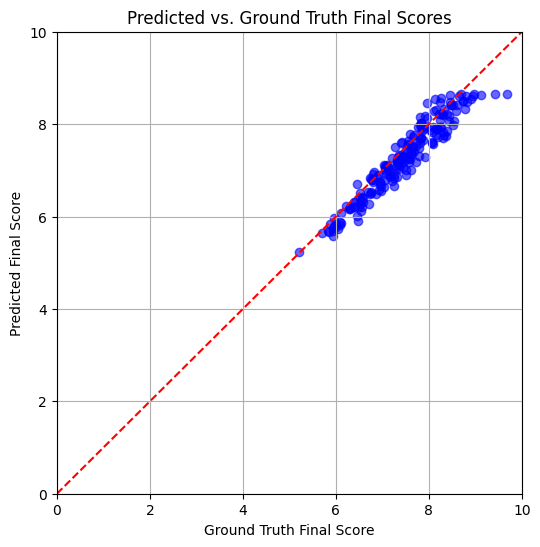

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions CSV
df = pd.read_csv("essay_ground_truth_predictions_multioutput.csv")

# Scatter plot: predicted vs ground truth final scores
plt.figure(figsize=(6,6))
plt.scatter(df['true_final'], df['pred_final'], alpha=0.6, color='blue')
plt.plot([0, 10], [0, 10], color='red', linestyle='--')  # ideal diagonal
plt.xlabel("Ground Truth Final Score")
plt.ylabel("Predicted Final Score")
plt.title("Predicted vs. Ground Truth Final Scores")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True)
plt.show()


# 22: Interactive Essay Scoring
We define a function to score any new essay interactively using:
- Semantic similarity between essay and topic prompt.
- Multi-output BERT model to predict grammar, coherence, and relevance.
- Grammar penalties computed using `language_tool_python`.

This enables users to input their own essays and get predicted scores in real-time.


**Run Interactive Essay Scoring Loop**
Users can type or paste essays in the input prompt. The system will return:
- Grammar score (with penalty)
- Coherence score
- Relevance score
- Final score (average of the three)
- Semantic similarity score (0–10 scale)

Type "quit" to exit the loop.


In [ ]:
# ================= Interactive Essay Scoring (Multi-Output) =================


# Load embedding model for semantic/relevance only
embed_model = SentenceTransformer("all-MiniLM-L6-v2", device=model.bert.device)

# Define topic prompts
topic_prompts = {
    "education": "Discuss the importance of education in modern society.",
    "environment": "Explain how humans can protect and improve the environment.",
    "ai": "Discuss the impact of artificial intelligence on society and daily life.",
    "health": "Explain why health and healthcare are important for society.",
    "other": "Discuss the given topic."
}

# ================= Define Essay Scoring Function =================
def score_essay(text):
    topic = "other"
    prompt_text = topic_prompts[topic]

    # Compute semantic/relevance feature
    essay_emb = embed_model.encode(text, convert_to_tensor=True)
    prompt_emb = embed_model.encode(prompt_text, convert_to_tensor=True)
    semantic_score = (util.cos_sim(essay_emb, prompt_emb).item() + 1)/2  # scaled 0-1

    # Build input_text for model
    input_text = f"Topic: {topic}. Prompt: {prompt_text}\n\nEssay: {text}"

    # Tokenize
    enc = tokenizer(
        input_text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    enc = {k: v.to(model.bert.device) for k, v in enc.items()}

    # Run multi-output BERT model
    with torch.no_grad():
        outputs = model(**enc)
        scores = outputs["logits"].squeeze().cpu().numpy()

    # ------------------------------
    # Sentence-level grammar penalty
    # ------------------------------
    matches = tool.check(text)
    grammar_penalty = len(matches) * 0.1  # reduce 0.1 point per detected error
    grammar_score = max(scores[0] - grammar_penalty, 0)  # ensure >= 0

    return {
        "grammar_score": float(grammar_score),
        "coherence_score": float(scores[1]),
        "relevance_score": float(scores[2]),
        "final_score": float(np.mean([grammar_score, scores[1], scores[2]])),
        "semantic_score": float(semantic_score*10)  # optional
    }

# ================= Interactive Loop =================
print("\n🟢 Interactive Essay Scoring Ready!")
print("Type or paste an essay below.")
print("Type 'quit' to exit.\n")

while True:
    user_input = input("📝 Enter essay: ")

    if user_input.lower().strip() in ["quit", "exit", "q"]:
        print("👋 Exiting essay scoring tool.")
        break

    if len(user_input.strip()) < 20:
        print("⚠️ Essay too short. Please enter at least 20 characters.\n")
        continue

    try:
        scores = score_essay(user_input)
        print(f"\n🎯 Predicted Final Score: {scores['final_score']:.2f}")
        print(f"✏️ Grammar Score: {scores['grammar_score']:.2f}")
        print(f"🔗 Coherence Score: {scores['coherence_score']:.2f}")
        print(f"📌 Relevance Score: {scores['relevance_score']:.2f}")
        print(f"💡 Semantic Score (0-10 scale, optional): {scores['semantic_score']:.2f}\n")
    except Exception as e:
        print("❌ Error scoring essay:", e, "\n")


NameError: name 'SentenceTransformer' is not defined

In [ ]:
from google.colab import files
import os
import shutil

# 🗑️ Step 0: Delete any leftover cleaned notebook from previous runs
safe_name = "cleaned_notebook.ipynb"
if os.path.exists(safe_name):
    os.remove(safe_name)
    print(f"🗑️ Removed old file: {safe_name}")

# 📤 Step 1: Upload your notebook file (.ipynb)
print("📤 Please upload your notebook file (.ipynb)...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 🧹 Step 2: Clean metadata using nbconvert
clean_name = filename.replace(".ipynb", "_clean.ipynb")
os.system(f"jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook \"{filename}\" --output \"{clean_name}\"")

# 🧼 Step 3: Rename to safe filename for download
shutil.move(clean_name, safe_name)

# 📥 Step 4: Download cleaned notebook
files.download(safe_name)
print(f"✅ Downloaded: {safe_name}")


📤 Please upload your notebook file (.ipynb)...


Saving FINAL_PROJECT.ipynb to FINAL_PROJECT (5).ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: cleaned_notebook.ipynb
